In [9]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# env
class RandomWalk:
    def __init__(self, n_states=1000, start_state=500, step_range=100):
        self.n_states = n_states
        self.states = np.arange(1, n_states + 1)
        self.start_state = start_state
        self.end_states = [0, n_states + 1]     # absorbing terminals
        self.step_range = step_range
        self.actions = [-1, 1]                  # left or right

    def step(self, state, action):
        # random stride length -> wide uncertainty over next state
        stride = np.random.randint(1, self.step_range + 1) * action

        # clamp to terminal boundaries
        state = max(min(state + stride, self.n_states + 1), 0)

        # only terminal states give non-zero reward
        reward = -1 if state == 0 else (1 if state == self.n_states + 1 else 0)
        return state, reward

    def get_action(self):
        return 1 if np.random.binomial(1, 0.5) else -1

class AggregationValueFunction:
    def __init__(self, n_states, num_groups):
        self.num_groups = num_groups
        self.group_size = n_states // num_groups   # each chunk width
        self.params = np.zeros(num_groups)         # value for each chunk
        self.end_states = [0, n_states + 1]

    def value(self, s):
        if s in self.end_states:
            return 0
        # find which aggregation bin the state belongs to
        idx = (s - 1) // self.group_size
        return self.params[idx]

    def update(self, delta, s):
        idx = (s - 1) // self.group_size
        self.params[idx] += delta

# run one entire episode from start -> terminal and applies TD(n) updates
class SemiGradientTD:
    def __init__(self, env, value_function):
        self.env = env
        self.vf = value_function

    def run_episode(self, n, alpha):
        state = self.env.start_state
        states = [state]
        rewards = [0]
        time, T = 0, float("inf")

        while True:
            time += 1
            if time < T:
                action = self.env.get_action()
                next_state, reward = self.env.step(state, action)
                states.append(next_state)
                rewards.append(reward)

                # terminal detected -> episode length fixed
                if next_state in self.env.end_states:
                    T = time
            update_time = time - n
            if update_time >= 0:
                G = sum(rewards[update_time + 1 : min(T, update_time + n) + 1])
                if update_time + n <= T:
                    G += self.vf.value(states[update_time + n])
                s_update = states[update_time]
                # skip terminal states in update
                if s_update not in self.env.end_states:
                    delta = alpha * (G - self.vf.value(s_update))
                    self.vf.update(delta, s_update)

            if update_time == T - 1:
                break
            state = next_state

# compute using dynamic programming
class TrueValueComputer:
    def __init__(self, env):
        self.env = env

    def compute(self):
        # initial guess
        n = self.env.n_states
        step_range = self.env.step_range
        true_value = np.arange(-n - 1, n + 3, 2) / (n + 1)

        # iterate Bellman updates until convergence
        while True:
            old_value = np.copy(true_value)
            for s in self.env.states:
                true_value[s] = 0
                # expected value under random policy
                for a in self.env.actions:
                    for step in range(1, step_range + 1):
                        ns = max(min(s + a * step, n + 1), 0)
                        true_value[s] += (1 / (2 * step_range)) * true_value[ns]

            if np.sum(np.abs(old_value - true_value)) < 1e-2:
                break
        true_value[0] = true_value[-1] = 0
        return true_value

# value function approximation for TD(1)
def figure_9_2_left(env, true_value):
    episodes = int(1e5)
    alpha = 2e-4
    vf = AggregationValueFunction(env.n_states, 10)
    td = SemiGradientTD(env, vf)
    for _ in tqdm(range(episodes)):
        td.run_episode(n=1, alpha=alpha)
    approx = [vf.value(i) for i in env.states]

    plt.plot(env.states, approx, label="TD(1)")
    plt.plot(env.states, true_value[1:-1], label="true value")
    plt.xlabel("state")
    plt.ylabel("value")
    plt.legend()
    plt.title("figure 9.2 (left)")
    plt.show()

# rms error vs. α (only n = 1)

def figure_9_2_right(env, true_value):
    alphas = np.arange(0, 1.1, 0.1)
    episodes = 10
    runs = 100
    errors = np.zeros(len(alphas))

    # multiple runs average out noise
    for _ in tqdm(range(runs)):
        for j, alpha in enumerate(alphas):
            vf = AggregationValueFunction(env.n_states, 20)
            td = SemiGradientTD(env, vf)

            # short episodes for error measurement
            for _ in range(episodes):
                td.run_episode(n=1, alpha=alpha)
                pred = np.array([vf.value(s) for s in env.states])
                errors[j] += np.sqrt(np.mean((pred - true_value[1:-1]) ** 2))
    errors /= (runs * episodes)

    plt.plot(alphas, errors, label="n = 1")
    plt.xlabel("alpha")
    plt.ylabel("rms error")
    plt.ylim([0.25, 0.55])
    plt.legend()
    plt.title("figure 9.2 (right)")
    plt.show()

100%|██████████| 100000/100000 [00:17<00:00, 5794.63it/s]


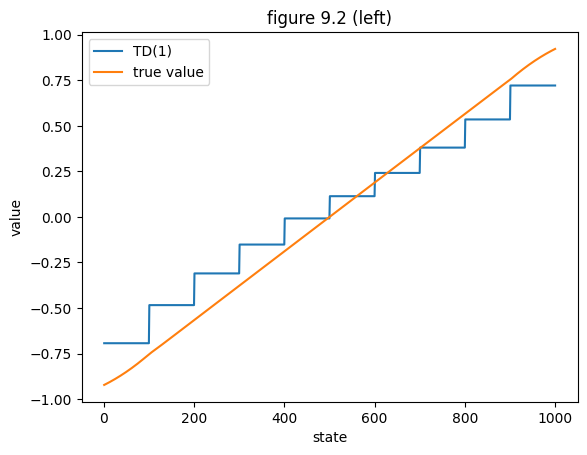

100%|██████████| 100/100 [00:03<00:00, 28.54it/s]


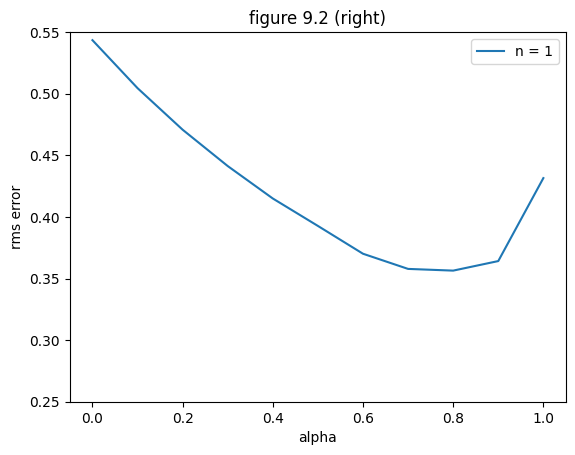

In [10]:
env = RandomWalk()
true_value = TrueValueComputer(env).compute()

figure_9_2_left(env, true_value)
figure_9_2_right(env, true_value)